---
title: "Borzoi prediction from personal genome"
author: "Sofia Salazar"
date: "2025-05-05"
description: 'Using Borzoi for predicting on a personal genome, derived from VCF'
format:
  html:
    code-fold: true
    code-summary: "Show the code"
    code-tools: true
    code-overflow: wrap
editor_options: 
  chunk_output_type: console
eval: false
categories:
  - gene46100
  - notebook
---

## 1. Set up

Recommended: create a new conda environment, borzoi is not compatible with python > 3.10

conda create --name borzoi46100 python=3.10

Then, use borzoi46100 environment to run the notebook


Install software repositories

In [1]:
import os
GITHUB_DIR = '/Users/haekyungim/Github'

# clone baskerville and borzoi if not already cloned
baskerville_path = os.path.join(GITHUB_DIR, 'baskerville')
borzoi_path = os.path.join(GITHUB_DIR, 'borzoi')
if not os.path.exists(baskerville_path):
    !git clone https://github.com/calico/baskerville.git {GITHUB_DIR}/baskerville

if not os.path.exists(borzoi_path):
    !git clone https://github.com/calico/borzoi.git {GITHUB_DIR}/borzoi

**After loading baskerville, restart runtime, run code from here**

Install libraries

In [2]:
try:
    import baskerville
except ImportError:
    !pip install -e {GITHUB_DIR}/baskerville


In [3]:
#| output: false

try:
    import borzoi
except ImportError:
    !pip install -e {GITHUB_DIR}/borzoi

NOTE: install tensorflow-metal if running on a mac

In [7]:
# import platform
# if platform.processor() == 'arm':
#     print("Apple Silicon detected, installing tensorflow-metal...")
#     %pip install tensorflow-metal
# else:
#     print("Not running on Apple Silicon, skipping tensorflow-metal installation")

Apple Silicon detected, installing tensorflow-metal...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Load libraries

In [4]:
#| output: false
try:
    import kipoiseq
except ImportError:
    %pip install kipoiseq
from kipoiseq import Interval
try:
    import cyvcf2
except ImportError:
    %pip install cyvcf2
import os
import time
import io
import gzip

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import baskerville
from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

import json

import pysam

import pyfaidx

import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Configure GPU device

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

Num GPUs Available:  1


### Dowload model files

In [8]:
PRE = '/Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100'
CONTENT_DIR = PRE + '/borzoi'
# Create borzoi/data directory if it doesn't exist
if not os.path.exists(os.path.join(CONTENT_DIR)):
    !mkdir {CONTENT_DIR}
if not os.path.exists(os.path.join(CONTENT_DIR, '/data')):
    !mkdir {CONTENT_DIR}/data

# Create model file structure
saved_models_path = os.path.join(CONTENT_DIR, 'data/saved_models')
if not os.path.exists(saved_models_path):
    !mkdir {saved_models_path}
if not os.path.exists(os.path.join(saved_models_path, 'f0')):
    !mkdir {saved_models_path}/f0
if not os.path.exists(os.path.join(saved_models_path, 'f1')):
    !mkdir {saved_models_path}/f1
if not os.path.exists(os.path.join(saved_models_path, 'f2')):
    !mkdir {saved_models_path}/f2
if not os.path.exists(os.path.join(saved_models_path, 'f3')):
    !mkdir {saved_models_path}/f3
    
#%cd {CONTENT_DIR}/data

mkdir: /Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/borzoi/data: File exists
/Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/borzoi/data


In [14]:
#DELET
os.path.join(CONTENT_DIR, 'data/hg38.fa')

'/Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/borzoi/data/hg38.fa'

In [11]:
#Download model weights
if not os.path.exists(os.path.join(saved_models_path, 'f0', 'model0_best.h5')):
    !wget https://storage.googleapis.com/seqnn-share/borzoi/f0/model0_best.h5 -O {saved_models_path}/f0/model0_best.h5
if not os.path.exists(os.path.join(saved_models_path, 'f1', 'model0_best.h5')): 
    !wget https://storage.googleapis.com/seqnn-share/borzoi/f1/model0_best.h5 -O {saved_models_path}/f1/model0_best.h5
if not os.path.exists(os.path.join(saved_models_path, 'f2', 'model0_best.h5')):
    !wget https://storage.googleapis.com/seqnn-share/borzoi/f2/model0_best.h5 -O {saved_models_path}/f2/model0_best.h5
if not os.path.exists(os.path.join(saved_models_path, 'f3', 'model0_best.h5')):
    !wget https://storage.googleapis.com/seqnn-share/borzoi/f3/model0_best.h5 -O {saved_models_path}/f3/model0_best.h5


In [28]:
#| output: false

#Download and uncompress annotation files
if not os.path.exists(os.path.join(CONTENT_DIR, 'data', 'gencode41_basic_nort.gtf')):
    !wget  -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > {os.path.join(CONTENT_DIR, 'data', 'gencode41_basic_nort.gtf')}
if not os.path.exists(os.path.join(CONTENT_DIR, 'data', 'gencode41_basic_protein_splice.csv.gz')):
    !wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz -O {os.path.join(CONTENT_DIR, 'data', 'gencode41_basic_protein_splice.csv.gz')}
if not os.path.exists(os.path.join(CONTENT_DIR, 'data', 'polyadb_human_v3.csv.gz')):
    !wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz -O {os. path.join(CONTENT_DIR, 'data', 'polyadb_human_v3.csv.gz')}

--2025-05-04 23:36:43--  https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.190.155, 142.250.191.123, 142.250.191.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.190.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30909907 (29M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]  29.48M  35.0MB/s    in 0.8s    

2025-05-04 23:36:45 (35.0 MB/s) - written to stdout [30909907/30909907]



### Download reference genome

In [15]:
#| output: false
#fasta_file = '/content/data/genome.fa'
fasta_file = os.path.join(CONTENT_DIR, 'data/hg38.fa')
if not os.path.exists(fasta_file):
    !wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}

In [17]:
### download vcf file and index for chromosome 22
VCF_FILE = os.path.join(CONTENT_DIR, 'data/ALL.chr22.shapeit2_integrated_SNPs_v2a_27022019.GRCh38.phased.gz')
if not os.path.exists(VCF_FILE):
    !wget https://uchicago.box.com/shared/static/u526pjh29w93ufn65yomlch4z8lkb1sp.gz -O {VCF_FILE}


--2025-05-04 23:18:01--  https://uchicago.box.com/shared/static/u526pjh29w93ufn65yomlch4z8lkb1sp.gz
Resolving uchicago.box.com (uchicago.box.com)... 74.112.186.157
Connecting to uchicago.box.com (uchicago.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/u526pjh29w93ufn65yomlch4z8lkb1sp.gz [following]
--2025-05-04 23:18:05--  https://uchicago.box.com/public/static/u526pjh29w93ufn65yomlch4z8lkb1sp.gz
Reusing existing connection to uchicago.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uchicago.app.box.com/public/static/u526pjh29w93ufn65yomlch4z8lkb1sp.gz [following]
--2025-05-04 23:18:06--  https://uchicago.app.box.com/public/static/u526pjh29w93ufn65yomlch4z8lkb1sp.gz
Resolving uchicago.app.box.com (uchicago.app.box.com)... 74.112.186.157
Connecting to uchicago.app.box.com (uchicago.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting respo

In [18]:
#!ls /content/data
!ls {CONTENT_DIR}/data

ALL.chr22.shapeit2_integrated_SNPs_v2a_27022019.GRCh38.phased.gz
gencode41_basic_nort.gtf
gencode41_basic_nort.gtf.gz
gencode41_basic_protein_splice.csv.gz
hg38.fa
polyadb_human_v3.csv.gz
saved_models


In [19]:
%cd {CONTENT_DIR}

/Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/borzoi


#### Download htslib to index genome

In [ ]:
#| output: false
!wget https://github.com/samtools/htslib/releases/download/1.9/htslib-1.9.tar.bz2
!tar -vxjf htslib-1.9.tar.bz2
%cd htslib-1.9
!autoreconf -i
!./configure
!make
!make install



In [21]:
## if you Permission denied error on a mac, try
!brew install htslib

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:40e7f5d7514a7e9757facdd39006f7a351d3d7986d3a228be13c8b1c3216727b
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.3.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
bkmr                       newsraft                   tdom
camlpdf                    policy-engine              tmex
elfio                      readerwriterqueue          undercutf1
iccmax                     rofi                       unoserver
infat                      sequoia-chameleon-gnupg
miniflux                   sexpect
==> New Casks
cloudpouch                               font-harmonyos-sans-sc
clover-chor

#### Index vcf

In [22]:
!tabix {VCF_FILE}

### Define paths

In [40]:
models_path = CONTENT_DIR + '/data/saved_models/'
params_file = GITHUB_DIR + '/borzoi/examples/params_pred.json'
targets_file = GITHUB_DIR + '/borzoi/examples/targets_human.txt'

Load splice site annotation

In [26]:
splice_df = pd.read_csv(CONTENT_DIR+'/data/gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')
print("len(splice_df) = " + str(len(splice_df)))

len(splice_df) = 404837


Load transcriptome

In [29]:
transcriptome = bgene.Transcriptome(CONTENT_DIR + '/data/gencode41_basic_nort.gtf')

## 2. Define functions

#### FastaStringExtractor
From reference seq fasta:
- Indexes ref sequence
- Gets chromosome sizes into a dictionary

Extract function:
- gets target chromosome length from kipoiseq interval and chr sizes dictionary
- truncates interval if it extends beyond chromosome lengths
- extracts sequence

#### make_seq_1hot
- one hot encodes given sequence

#### predict_tracks
- makes prediction of ALL tracks given an encoded sequence


In [31]:
class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    #import pd.Interval as Interval

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream # returns padded sequence

    def close(self):
        return self.fasta.close()

In [32]:
# Make one-hot coded sequence (modified from borzoi)
def make_seq_1hot(sequence):
    return dna.dna_1hot(sequence).astype("float32")

def predict_tracks(models, sequence_one_hot):

  predicted_tracks = []
  for fold_ix in range(len(models)):

    yh = models[fold_ix](sequence_one_hot[None, ...])[:, None, ...].astype("float16")

    predicted_tracks.append(yh)

  predicted_tracks = np.concatenate(predicted_tracks, axis=1)

  return predicted_tracks


#### vcf_to_seq_faster
- Modifies ref sequence to personal sequence given the vcf

In [33]:
def vcf_to_seq_faster(target_interval, individual, vcf_file, fasta_extractor):
  # target_inverval is a kipoiseq interval, e.g. kipoiseq.Interval("chr22", 18118779, 18145669)
  # individual is the id of the individual in the vcf file

  target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))
  window_coords = target_interval.resize(SEQUENCE_LENGTH)
      # two haplotypes per individual
  haplo_1 = list(target_fa[:])
  haplo_2 = list(target_fa[:])

  # Open the VCF file
  vcf_reader = cyvcf2.VCF(vcf_file)

  # Specific genomic region
  CHROM = window_coords.chrom
  START = max(1,window_coords.start)
  END = min(window_coords.end, fasta_extractor._chromosome_sizes[CHROM]-1)

  count1 = 0
  count2 = 0

  # Iterate through variants in the specified region
  for variant in vcf_reader(CHROM + ':' + str(START) + '-' + str(END)):
      # Access the individual's genotype using index (0-based) of the sample
      individual_index = vcf_reader.samples.index(individual)
      genotype = variant.genotypes[individual_index]
      ALT=variant.ALT[0]
      REF=variant.REF
      POS=variant.POS
      if REF == target_fa[POS - window_coords.start - 1]:
        if genotype[0] == 1:
          haplo_1[POS - window_coords.start - 1] = ALT
          count1 = count1 + 1
        if genotype[1] == 1:
          haplo_2[POS - window_coords.start - 1] = ALT
          count2 = count2 + 1
      else:
        print("ERROR: REF in vcf "+ REF + "!= REF from the build" + target_fa[POS - window_coords.start - 1])
  print("number of changes haplo1:")
  print(count1)
  print("number of changes haplo2:")
  print(count2)
  return haplo_1, haplo_2

#### make_prediction function

In [34]:
def make_prediction(gene, interval, haplo, sequence_one_hot, window = 131072): # snp_pos, alt_allele
    with tf.device('/GPU:0'):
        search_gene = gene # gene to predict

        resized_interval = interval.resize(SEQUENCE_LENGTH)
        start = resized_interval.start
        end = resized_interval.end
        center_pos = start + SEQUENCE_LENGTH//2 # figure center position

        chrom = resized_interval.chr # chromosome

        #Get exon bin range
        gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

        gene = transcriptome.genes[gene_keys[0]]

        #Determine output sequence start
        seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
        seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

        #Determine output positions of gene exons
        gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)

        #Make predictions
        #y_wt
        return predict_tracks(models, sequence_one_hot)


#### Get indexes of tracks function

In [35]:
# Get indexes of track
def get_track_idx(tracks):
  track_idx = []
  targets_df['local_index'] = np.arange(len(targets_df))
  for track in tracks:
    track_idx.append(targets_df.loc[targets_df['description'] == track]['local_index'].tolist())
  return track_idx

#### Plot tracks function

In [36]:
def plot_tracks(prediction, interval, haplo, anno_df=None, tracks=[],
                log = [False, False, False],
                sqrt_scale = [False, False, False]):
  # Gene slice not included
  bin_size = 32
  pad = 16

  resized_interval = interval.resize(SEQUENCE_LENGTH)
  start = resized_interval.start
  end = resized_interval.end
  center_pos = start + SEQUENCE_LENGTH//2 # figure center position
  window=131072

  plot_start = center_pos - window // 2
  plot_end = center_pos + window // 2

  plot_start_bin = (plot_start - start) // bin_size - pad
  plot_end_bin = (plot_end - start) // bin_size - pad

  track_idx = get_track_idx(tracks)
  track_scales = [0.01, 0.01, 0.01]
  track_transforms = [3./4., 3./4., 3./4.]
  soft_clips = [384., 384., 384.]

  # Get annotation positions
  anno_poses = []
  if anno_df is not None:
      anno_poses = anno_df.query(
          "chrom == '"
          + interval.chr
          + "' and position_hg38 >= "
          + str(plot_start)
          + " and position_hg38 < "
          + str(plot_end)
        )["position_hg38"].values.tolist()
  # BIG plot
  fig, axes = plt.subplots(len(tracks), figsize=(20, 1.5 * len(tracks)), sharex = True)

  for ax, track, track_index, track_scale, track_transform, clip_soft in zip(axes,
        tracks, track_idx, track_scales, track_transforms, soft_clips):
    # Plot track densities
    y = np.array(np.copy(prediction), dtype = np.float32)
    y = np.mean(y[..., track_index], axis=(0, 1, 3))
    y = y[plot_start_bin:plot_end_bin]
    signal = np.max(y)
    if log:
      y = np.log2(y + 1.0)
    elif sqrt_scale:
      y = np.sqrt(y + 1.0)

    max_y = np.max(y)
    print("Max signal for "+ str(track) + " = " + str(round(signal, 4)))
    print("Max transformed signal for "+ str(track) + " = " + str(round(max_y, 4)))
    print("---")
    ax.bar(np.arange(plot_end_bin - plot_start_bin) + plot_start_bin,
            y,
            width=1.0,
            color="green",
            alpha=0.5)
            # label="Prediction",)
    # X axis tick annotations
    xtick_vals = []
    for _, anno_pos in enumerate(anno_poses):
      pas_bin = int((anno_pos - start) // 32) - 16
      xtick_vals.append(pas_bin)
      bin_end = pas_bin + 3 - 0.5
      bin_start = bin_end - 5

      ax.axvline(x=pas_bin,
                color="cyan",
                linewidth=2,
                alpha=0.5,
                linestyle="-",
                zorder=-1,)

    plt.xlim(plot_start_bin, plot_end_bin - 1)
    plt.xticks([], [])
    plt.yticks([], [])

    ax.set(ylabel = "Signal(log)" if log else "Signal")# , fontsize = 8)
    ax.set_title("Track: " + str(track)+ " in "+ str(haplo), fontsize=10)
    # plt.legend(fontsize=8)
    plt.tight_layout()
  ax.set_xlabel(
            interval.chr
            + ":"
            + str(plot_start)
            + "-"
            + str(plot_end)
            + " ("
            + str(window)
            + "bp window)")
            # fontsize=8,)
  plt.show()

### Extract fasta

In [37]:
fasta_extractor = FastaStringExtractor(fasta_file)

## 3.Model configuration

In [43]:
#| output: false
SEQUENCE_LENGTH = 524288
n_folds = 4       #To use only one model fold, change to 'n_folds = 1'
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :

    params = json.load(params_open)

    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair

    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')


In [47]:

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :

    model_file = models_path + "f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    #seqnn_model.build_ensemble(rc, '0')
    seqnn_model.build_ensemble(rc, [0])

    models.append(seqnn_model)

## 4. Build sequence

In [49]:
# read VCFs and encode haplotypes
CHROM = 'chr22'
vcf_file = CONTENT_DIR + "/data/ALL." + CHROM + ".shapeit2_integrated_SNPs_v2a_27022019.GRCh38.phased.gz"
target_interval = kipoiseq.Interval(CHROM, 18118779, 18145669)
haplo1, haplo2 = vcf_to_seq_faster(target_interval, 'HG00097', vcf_file, fasta_extractor)
haplo0 = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)) # ref seq

# removed extra dimension as input layer is of shape=(None, 524288, 4)
haplo1_enc = make_seq_1hot("".join(haplo1))
haplo2_enc = make_seq_1hot("".join(haplo2))
haplo0_enc = make_seq_1hot("".join(haplo0))

number of changes haplo1:
414
number of changes haplo2:
133


## 5. Predict

ENSG00000099968

In [50]:
sequences = [haplo0_enc, haplo1_enc, haplo2_enc]
my_tracks = ['CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_',
                          'DNASE:CD14-positive monocyte female',
                          'RNA:blood']

Reference
Max signal for CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_ = 38.1346
Max transformed signal for CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_ = 5.2904
---
Max signal for DNASE:CD14-positive monocyte female = 11.8511
Max transformed signal for DNASE:CD14-positive monocyte female = 3.6838
---
Max signal for RNA:blood = 2.7051
Max transformed signal for RNA:blood = 1.8895
---


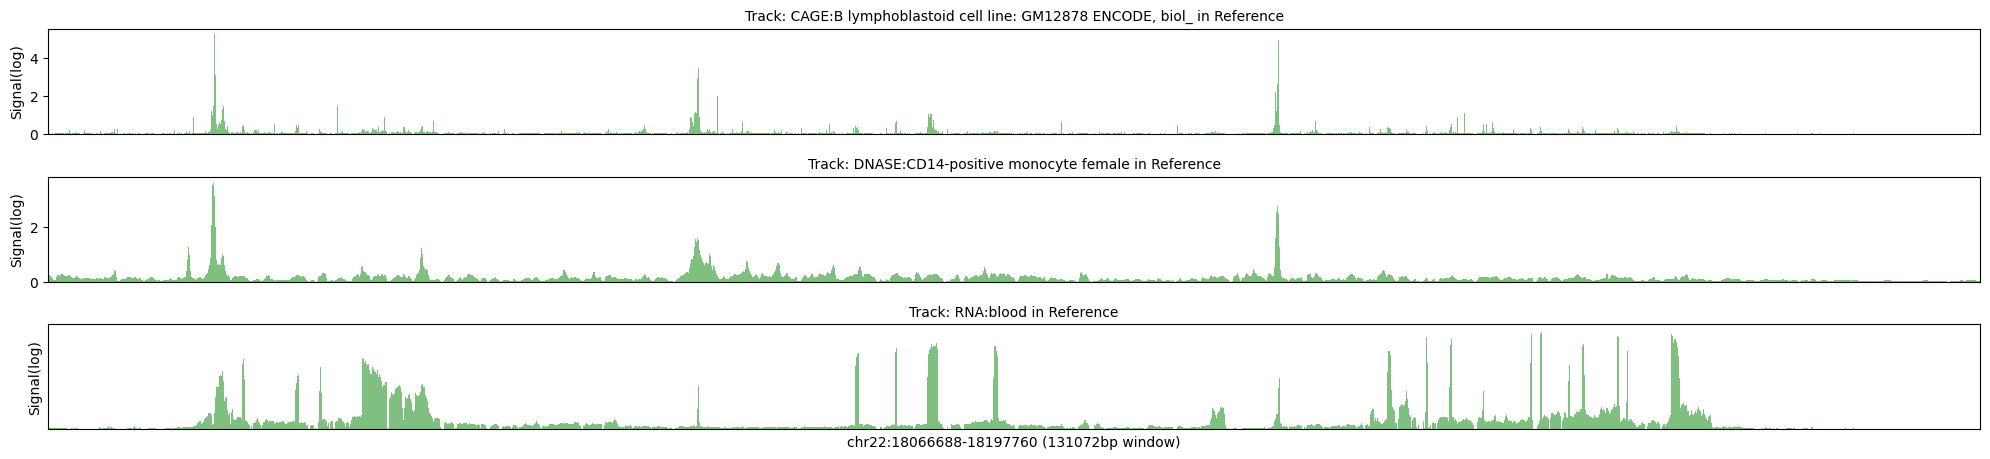

Haplotype 1
Max signal for CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_ = 39.2737
Max transformed signal for CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_ = 5.3318
---
Max signal for DNASE:CD14-positive monocyte female = 11.8428
Max transformed signal for DNASE:CD14-positive monocyte female = 3.6829
---
Max signal for RNA:blood = 2.689
Max transformed signal for RNA:blood = 1.8832
---


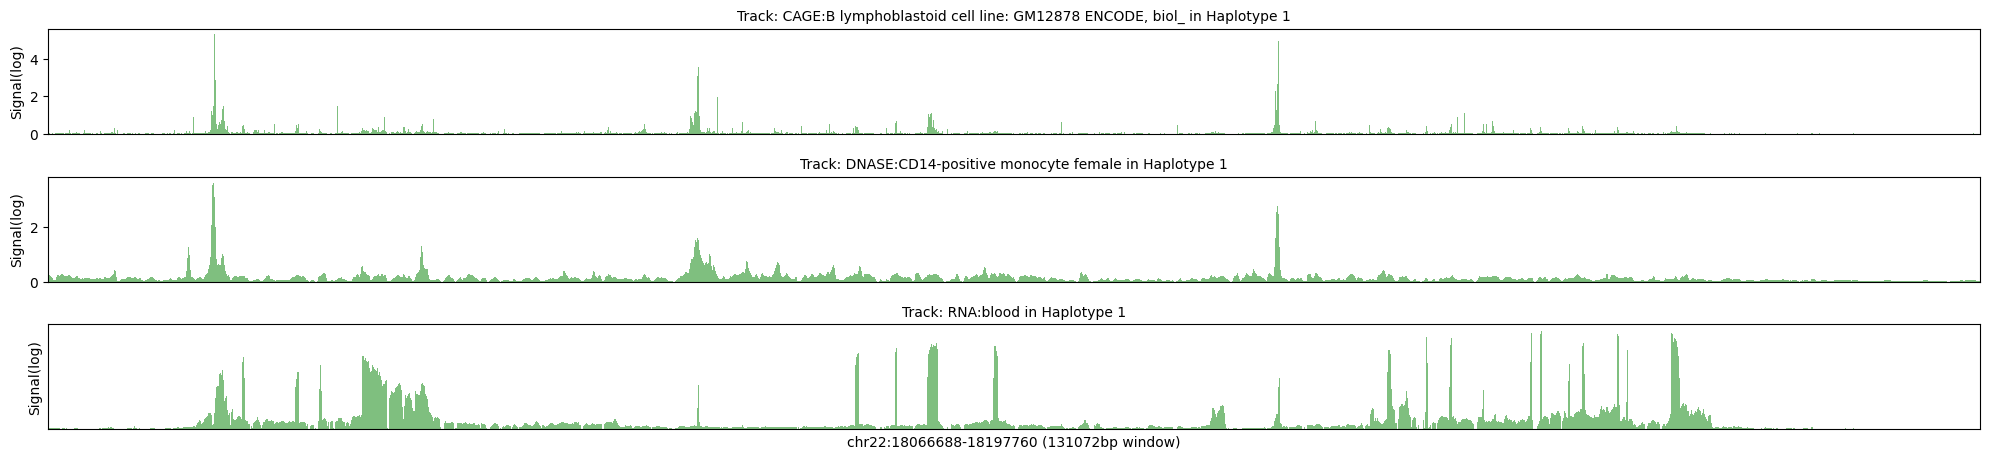

Haplotype 2
Max signal for CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_ = 38.5659
Max transformed signal for CAGE:B lymphoblastoid cell line: GM12878 ENCODE, biol_ = 5.3062
---
Max signal for DNASE:CD14-positive monocyte female = 11.8301
Max transformed signal for DNASE:CD14-positive monocyte female = 3.6815
---
Max signal for RNA:blood = 2.7414
Max transformed signal for RNA:blood = 1.9036
---


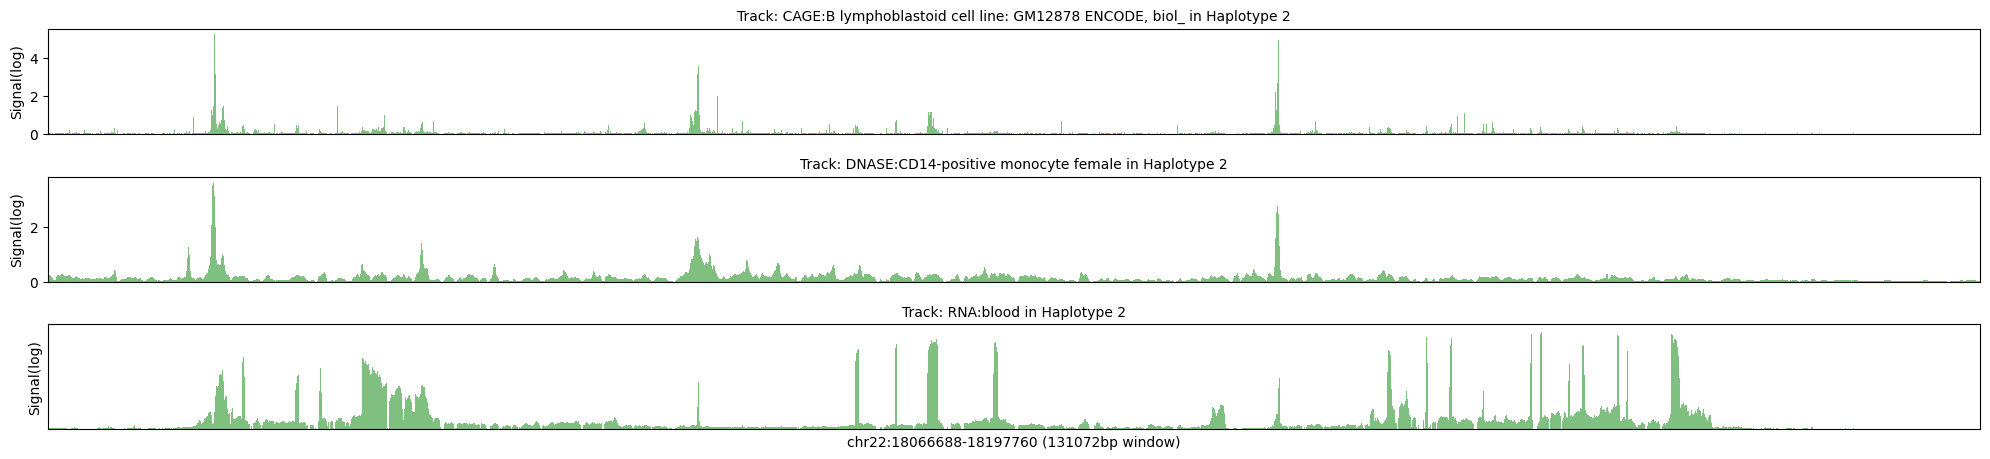

In [51]:
for h in range(0, len(sequences)):
  haplotypes = ["Reference", "Haplotype 1", "Haplotype 2"]
  prediction = make_prediction(gene = 'ENSG00000099968', interval = target_interval,
                               haplo = haplotypes[h], sequence_one_hot=sequences[h])
  print(haplotypes[h])
  plot_tracks(prediction, interval = target_interval, haplo = haplotypes[h],
              tracks = my_tracks, log = [True, True, False])

In [52]:
prediction.shape

(1, 4, 16352, 7611)